In [1]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from acquire_cluster import my_db, my_train_test_split, clean_zillow
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.cluster import KMeans



In [2]:
zillow = my_db(''' SELECT prop.*,
                      predictions_2017.logerror,
                      predictions_2017.transactiondate,
                      air.airconditioningdesc,
                      arch.architecturalstyledesc,
                      build.buildingclassdesc,
                      heat.heatingorsystemdesc,
                      land.propertylandusedesc,
                      story.storydesc,
                      type.typeconstructiondesc
FROM properties_2017 prop
JOIN (
    SELECT parcelid, MAX(transactiondate) AS max_transactiondate
FROM predictions_2017
GROUP BY parcelid
) pred USING(parcelid)
JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
AND pred.max_transactiondate = predictions_2017.transactiondate
LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
LEFT JOIN storytype story USING(storytypeid)
LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
WHERE propertylandusedesc = "Single Family Residential"
AND transactiondate <= '2017-12-31'
AND prop.longitude IS NOT NULL
AND prop.latitude IS NOT NULL''', 'zillow')

In [3]:
zillow = clean_zillow(zillow)

In [4]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32703 entries, 3 to 52318
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            32703 non-null  int64  
 1   parcelid                      32703 non-null  int64  
 2   bathroomcnt                   32703 non-null  float64
 3   bedroomcnt                    32703 non-null  float64
 4   calculatedbathnbr             32703 non-null  float64
 5   calculatedfinishedsquarefeet  32703 non-null  float64
 6   finishedsquarefeet12          32703 non-null  float64
 7   fips                          32703 non-null  float64
 8   fullbathcnt                   32703 non-null  float64
 9   latitude                      32703 non-null  float64
 10  longitude                     32703 non-null  float64
 11  lotsizesquarefeet             32703 non-null  float64
 12  poolcnt                       32703 non-null  float64
 13  p

In [5]:
train, validate, test = my_train_test_split(zillow)

In [6]:
trainExplore = train
trainExplore['logerror_bin'] = pd.cut(train.logerror, [-5,-1,-.75,-.5,-.25,0,.25,.50,.75, 1, 5])
trainExplore['latitude_bin'] = pd.cut(train.latitude, [0,33600000,34200000,34600000,35000000])
trainExplore['longitude_bin'] = pd.cut(train.longitude, [-119200000,-119000000,-118600000,-117800000,0])
trainExplore['squarefeet_bin'] = pd.cut(train.calculatedfinishedsquarefeet,[0,3000,8000,12000])
trainExplore['age'] = 2023 - train.yearbuilt
trainExplore['age_bin'] = pd.cut(train.age, [0,30,60,90,120])
trainExplore['lowerrors'] = pd.cut(train.logerror, [-.25,0,.25,.5])

In [7]:
impfeats = train[['calculatedfinishedsquarefeet','age','latitude','longitude','lotsizesquarefeet']]

In [8]:
clusters = pd.DataFrame([])
for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(impfeats)
    train['clusters',i] = kmeans.predict(impfeats)
    clusters['clusters',i] = kmeans.predict(impfeats)


In [21]:
impfeats

,calculatedfinishedsquarefeet,age,latitude,longitude,lotsizesquarefeet,bestCluster
30264,3293.0,79.0,33765739.0,-118128800.0,5603.0,3
19472,1050.0,94.0,34005601.0,-118072460.0,4354.0,2
44988,2054.0,60.0,33955835.0,-117979717.0,45019.0,2
4569,1523.0,69.0,33892079.0,-118109802.0,5495.0,3
35343,2028.0,58.0,33998279.0,-117841350.0,8569.0,2
...,...,...,...,...,...,...
2279,1332.0,75.0,34117215.0,-118076650.0,7763.0,2
12512,1675.0,64.0,34236834.0,-118267132.0,7451.0,0
27005,960.0,100.0,34018700.0,-118162819.0,3945.0,3
3366,1242.0,84.0,33939606.0,-118188488.0,5008.0,3


Clusters against location:

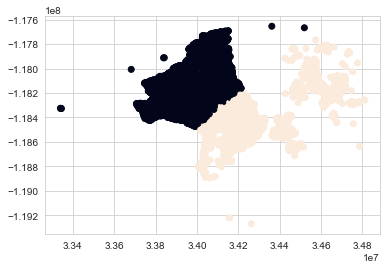

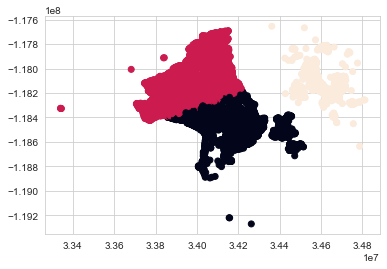

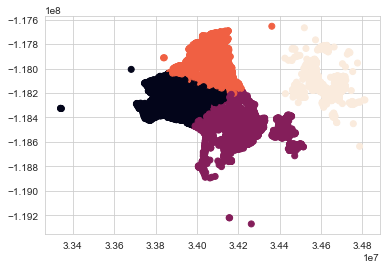

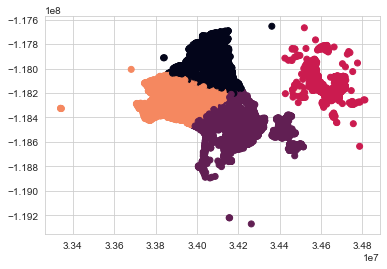

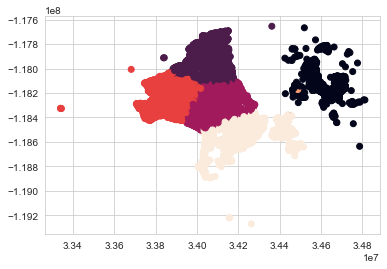

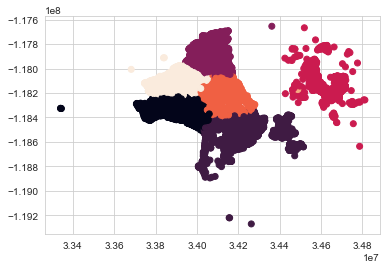

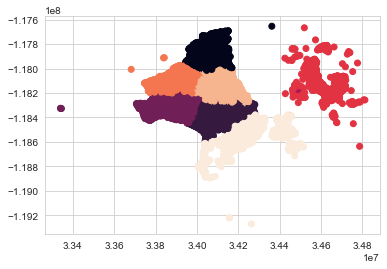

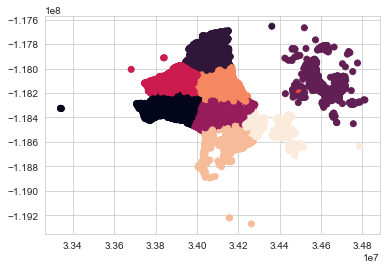

In [10]:
for x in clusters.columns:
    plt.scatter(train.latitude,train.longitude, c = clusters[x])
    plt.show()

Clusters against square feet and age

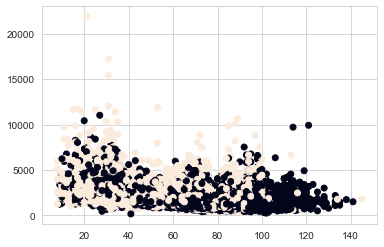

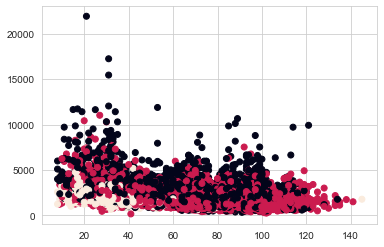

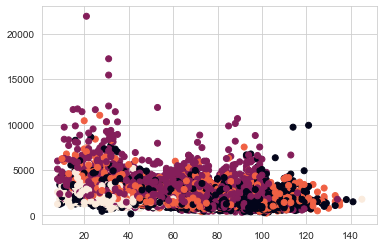

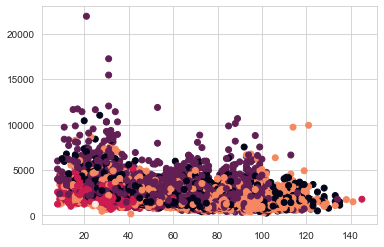

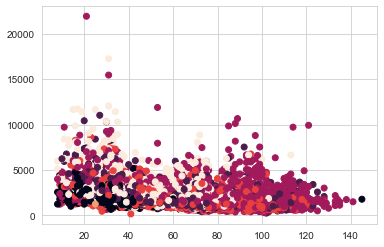

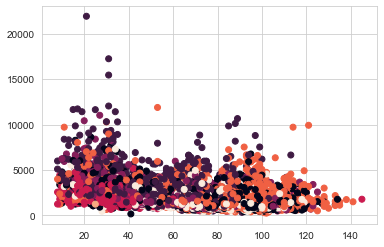

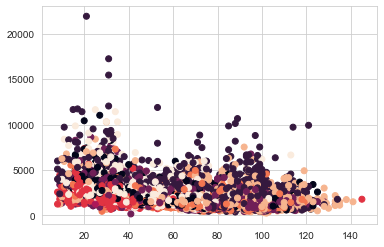

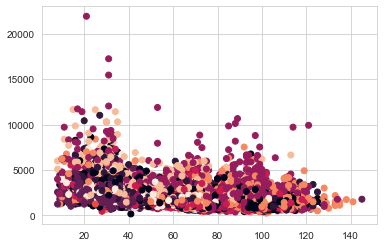

In [11]:
for x in clusters.columns:
    plt.scatter(train.age,train.calculatedfinishedsquarefeet, c = clusters[x])
    plt.show()

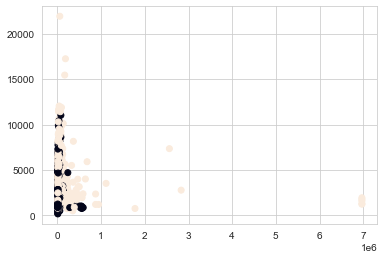

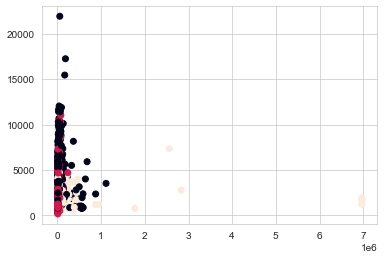

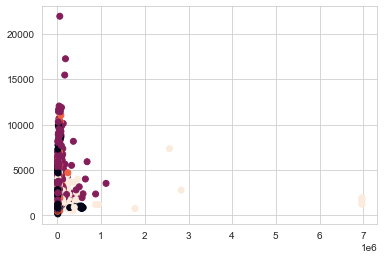

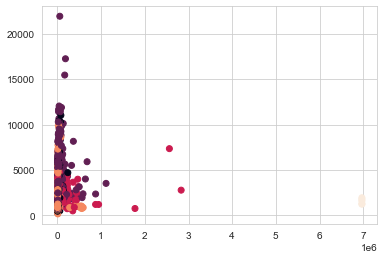

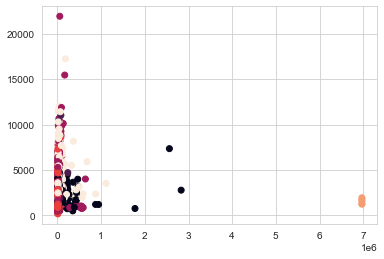

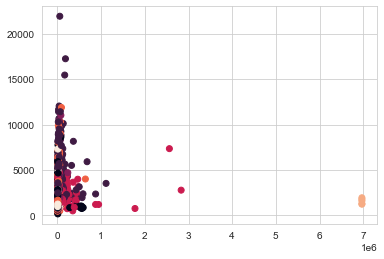

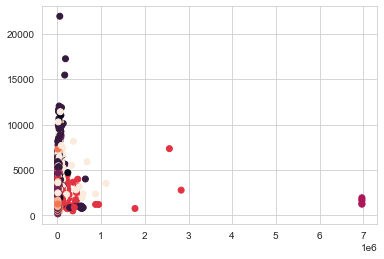

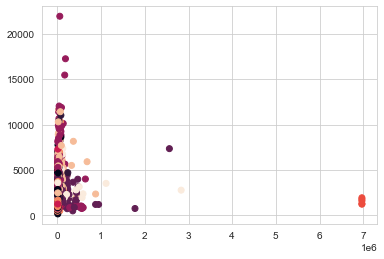

In [22]:
for x in clusters.columns:
    plt.scatter(train.lotsizesquarefeet,train.calculatedfinishedsquarefeet, c = clusters[x])
    plt.show()

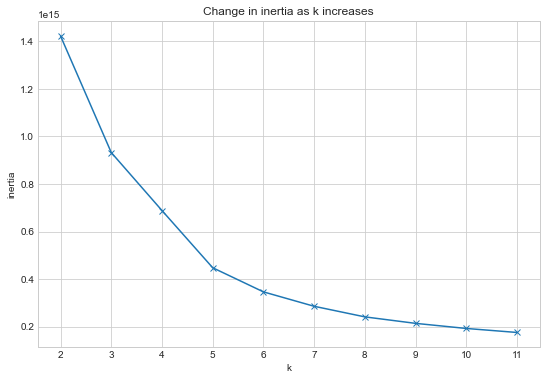

In [12]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(impfeats).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


BEST k val at 4

In [15]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(impfeats)
train['bestCluster'] = kmeans.predict(impfeats)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=impfeats.columns)
centroids
train.groupby('bestCluster')['latitude', 'longitude'].mean()


,latitude,longitude
bestCluster,,
0,3.419501e+07,-1.184622e+08
1,3.406258e+07,-1.179747e+08
2,3.391424e+07,-1.182482e+08
3,3.462735e+07,-1.181234e+08


Text(0.5, 1.0, 'Visualizing Cluster Centers')

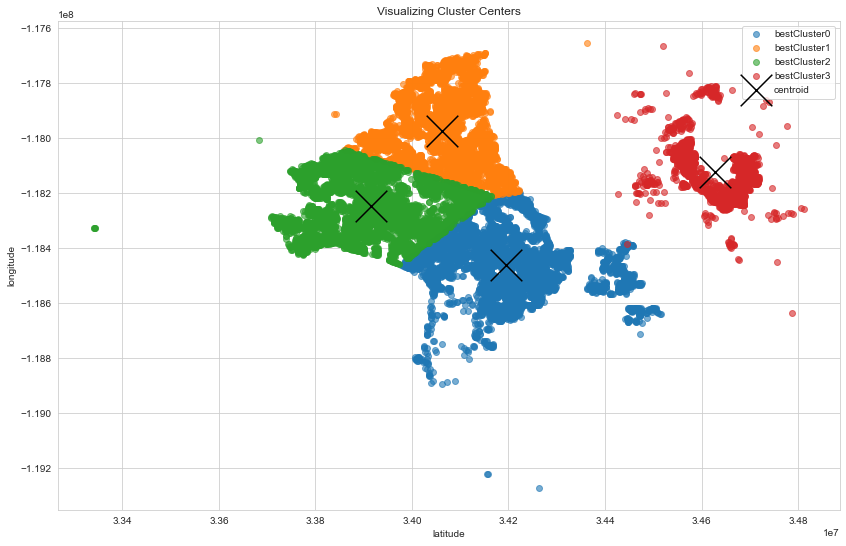

In [20]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('bestCluster'):
    plt.scatter(subset.latitude, subset.longitude,label = 'bestCluster' + str(cluster),  alpha=.6)

centroids.plot.scatter(y='longitude', x='latitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Cluster Centers')
